## Music generation project - separate inputs/outputs

In this notebook we build a final model which is the most accurate one. There is no difference in the preprocessing with respect to the notebook with 3 different models until creation of the datasets. 

In [772]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from music21 import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from fractions import Fraction
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline

### Preprocessing

In [779]:
filepaths = glob.glob('data/*.mid')

In [780]:
filepaths

['data\\Bach_-_Sonata_No._1_in_G_minor_-_BWV_1001_-_Presto.mid',
 'data\\Concerto_in_A_minor_A_Vivaldi.mid',
 'data\\Fur_Elise.mid',
 'data\\Solo_Violin_Caprice_No._24_in_A_Minor_-_N._Paganini_Op._1_No._24.mid',
 'data\\Solo_Violin_Partita_No._2_in_D_Minor_-_J._S._Bach_BWV_1004.mid',
 'data\\Solo_Violin_Partita_No._3_in_E_Major_-_J._S._Bach_BWV_1006.mid',
 'data\\Solo_Violin_Sonata_No._1_in_G_Minor_-_J._S._Bach_BWV_1001.mid',
 'data\\Solo_Violin_Sonata_No._2_in_A_Minor_-_J._S._Bach_BWV_1003.mid',
 'data\\Spring-Four_seasons_vivaldi.mid']

In [781]:
def read_parse_midi(file):
    midi = converter.parse(file)
    notes_to_parse = None
    notes = []
    durations = []
    offsets = []
    
    parts = instrument.partitionByInstrument(midi)

    for part in parts:
        if 'Violin' or 'StringInstrument' in str(part):
            notes_to_parse = part.recurse()
            for i in range(len(notes_to_parse)):
                if isinstance(notes_to_parse[i], note.Note):
                    notes.append(str(notes_to_parse[i].pitch))
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
                elif isinstance(notes_to_parse[i], chord.Chord):
                    notes.append('.'.join(str(n) for n in notes_to_parse[i].normalOrder))
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
                elif isinstance(notes_to_parse[i], note.Rest):
                    notes.append(notes_to_parse[i].name)
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
    return np.array(notes), np.array(durations), np.array(offsets)

In [782]:
notes_durations_offsets = [read_parse_midi(file) for file in filepaths]

In [783]:
notes_full = [notes_durations_offsets[i][0] for i in range(len(notes_durations_offsets))]
durations_full = [notes_durations_offsets[i][1] for i in range(len(notes_durations_offsets))]
offsets_full = [notes_durations_offsets[i][2] for i in range(len(notes_durations_offsets))]

In [784]:
all_notes = [element for notes in notes_full for element in notes] 
all_durations = [element for durations in durations_full for element in durations]
all_offsets = [element for offsets in offsets_full for element in offsets]
unique_notes = set(all_notes)
unique_durations = set(all_durations)
unique_offsets = set(all_offsets)

In [785]:
num_to_notes = dict([i for i in enumerate(sorted(list(unique_notes)))])
notes_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_notes)))])

In [786]:
num_to_dur = dict([i for i in enumerate(sorted(list(unique_durations)))])
dur_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_durations)))])

In [787]:
num_to_off = dict([i for i in enumerate(sorted(list(unique_offsets)))])
off_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_offsets)))])

In [788]:
notes_full_map = [list(map(notes_to_num.get, i)) for i in notes_full]

In [789]:
durations_full_map = [list(map(dur_to_num.get, i)) for i in durations_full]

In [790]:
offsets_full_map = [list(map(off_to_num.get, i)) for i in offsets_full]

Similarly to the other model to make predictions we need some starting points which can be chosen randomly or taken from the validation set. Here we don't use the validation set but the entire data combined in tuples for each symbol as it can be seen below. Even though we have 3 separate models, starting points are correlated in terms of note, duration and offset.

In [33]:
full_data = [list(zip(notes_full_map[i], durations_full_map[i], offsets_full_map[i])) for i in range(len(notes_full_map))]

In [34]:
full_data[0][:10]

[(209, 3, 0),
 (171, 3, 3),
 (209, 3, 3),
 (186, 3, 3),
 (209, 3, 3),
 (186, 3, 3),
 (170, 3, 3),
 (186, 3, 3),
 (170, 3, 3),
 (208, 3, 3)]

Since the functional API in keras does not easily support tf.datasets, we have to use arrays or tensors instead and separate features from targets. Therefore we split the entire dataset for train set and validation set and then extract notes, durations and offsets. Batches are created in the *fit* method when training is initialized.

In [791]:
def create_datasets(data, n_steps=100, batch_size=32, train_size=0.8):
    window_length = n_steps + 1
    datasets = []
    for j in full_data:
        dataset = tf.data.Dataset.from_tensor_slices(j)
        dataset = dataset.window(window_length, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_length))
        datasets.append(dataset)
        
    dataset_final = datasets[0]
    for k in datasets[1:]:
        dataset_final = dataset_final.concatenate(k)

    dataset_final = dataset_final.map(lambda window: (window[:-1, :], window[1:, :]))
    dataset_final = dataset_final.shuffle(30000)
    
    train_set, val_set = train_test_split(list(dataset_final), test_size=0.2)
    
    return train_set, val_set

In [792]:
train_set, val_set = create_datasets(full_data)

In [793]:
train_notes = tf.convert_to_tensor([i[0][:, 0] for i in train_set])
targets_notes = tf.convert_to_tensor([i[1][:, 0] for i in train_set])

train_durations = tf.convert_to_tensor([i[0][:, 1] for i in train_set])
targets_durations = tf.convert_to_tensor([i[1][:, 1] for i in train_set])

train_offsets = tf.convert_to_tensor([i[0][:, 2] for i in train_set])
targets_offsets = tf.convert_to_tensor([i[1][:, 2] for i in train_set])

In [794]:
val_notes = tf.convert_to_tensor([i[0][:, 0] for i in val_set])
val_targets_notes = tf.convert_to_tensor([i[1][:, 0] for i in val_set])

val_durations = tf.convert_to_tensor([i[0][:, 1] for i in val_set])
val_targets_durations = tf.convert_to_tensor([i[1][:, 1] for i in val_set])

val_offsets = tf.convert_to_tensor([i[0][:, 2] for i in val_set])
val_targets_offsets = tf.convert_to_tensor([i[1][:, 2] for i in val_set])

In [795]:
train_set[505]

(<tf.Tensor: shape=(100, 3), dtype=int32, numpy=
 array([[182,   3,   3],
        [175,   3,   3],
        [201,   3,   3],
        [186,   3,   3],
        [182,   3,   3],
        [186,   3,   3],
        [174,   3,   3],
        [204,   3,   3],
        [174,   3,   3],
        [182,   3,   3],
        [194,   3,   3],
        [167,   3,   3],
        [205,   3,   3],
        [167,   3,   3],
        [194,   3,   3],
        [182,   3,   3],
        [194,   3,   3],
        [209,   3,   3],
        [194,   3,   3],
        [178,   3,   3],
        [174,   3,   3],
        [178,   3,   3],
        [166,   3,   3],
        [193,   3,   3],
        [208,   3,   3],
        [200,   3,   3],
        [186,   3,   3],
        [166,   3,   3],
        [208,   3,   3],
        [166,   3,   3],
        [200,   3,   3],
        [185,   3,   3],
        [200,   3,   3],
        [173,   3,   3],
        [185,   3,   3],
        [204,   3,   3],
        [197,   3,   3],
        [204,   3,   3],
 

In [796]:
train_offsets[505]

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3])>

In [797]:
targets_offsets[505]

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3])>

### Training

The architecture is similar to the previous models but now we have 3 inputs so also 3 Embedding layers which are concatenated and additionally Input layers have to be set. There are also 3 Dense layers with number of units given be the unique values in notes, durations and offsets. Model has to be build with the functional API. Training was done for 15 epochs which gave more than 90% accuracy at all 3 outputs.

In [599]:
n_embedding_dims = 5

notes_input = keras.layers.Input(shape=(None,))
durations_input = keras.layers.Input(shape=(None,))
offsets_input = keras.layers.Input(shape=(None,))

note_embedding = keras.layers.Embedding(input_dim=len(unique_notes), output_dim=n_embedding_dims,
                       input_length=None)(notes_input)
duration_embedding = keras.layers.Embedding(input_dim=len(unique_durations), output_dim=n_embedding_dims,
                       input_length=None)(durations_input)
offset_embedding = keras.layers.Embedding(input_dim=len(unique_durations), output_dim=n_embedding_dims,
                       input_length=None)(offsets_input)

concat = keras.layers.Concatenate(axis=2)([note_embedding, duration_embedding, offset_embedding])

conv_1 = keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu")(concat)
batch_1 = keras.layers.BatchNormalization()(conv_1)
conv_2 = keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2)(batch_1)
batch_2 = keras.layers.BatchNormalization()(conv_2)
conv_3 = keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4)(batch_2)
batch_3 = keras.layers.BatchNormalization()(conv_3)
conv_4 = keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8)(batch_3)
batch_4 = keras.layers.BatchNormalization()(conv_4)
lstm_layer = keras.layers.LSTM(256, return_sequences=True)(batch_4)

notes_output = keras.layers.Dense(len(unique_notes), activation="softmax")(lstm_layer)
durations_output = keras.layers.Dense(len(unique_durations), activation="softmax")(lstm_layer)
offsets_output = keras.layers.Dense(len(unique_offsets), activation="softmax")(lstm_layer)

final_model = keras.Model(inputs=[notes_input, durations_input, offsets_input], 
                          outputs=[notes_output, durations_output, offsets_output])

checkpoint_cb = keras.callbacks.ModelCheckpoint('model_full.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   

In [600]:
final_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_108 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_109 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
input_110 (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_105 (Embedding)       (None, None, 5)      1060        input_108[0][0]                  
___________________________________________________________________________________________

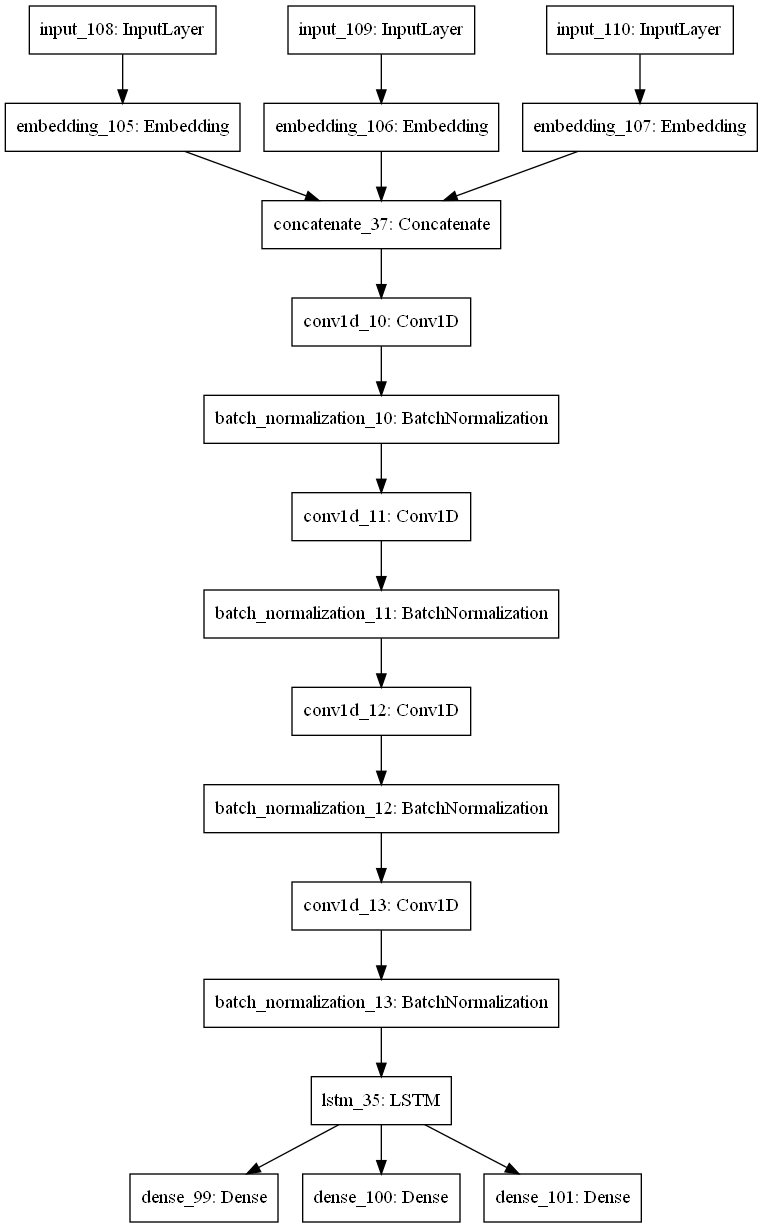

In [601]:
keras.utils.plot_model(final_model)

In [603]:
history = final_model.fit([train_notes, train_durations, train_offsets], [targets_notes, targets_durations, targets_offsets],
                    epochs=15, batch_size=64,
                    validation_data=((val_notes, val_durations, val_offsets), 
                                     (val_targets_notes, val_targets_durations, val_targets_offsets)), 
                    callbacks=[checkpoint_cb, early_stopping])

Epoch 1/15
360/360 [==============================] - 85s 237ms/step - loss: 3.3315 - dense_99_loss: 2.6262 - dense_100_loss: 0.4918 - dense_101_loss: 0.2136 - dense_99_accuracy: 0.2652 - dense_100_accuracy: 0.8635 - dense_101_accuracy: 0.9404 - val_loss: 4.9609 - val_dense_99_loss: 3.4858 - val_dense_100_loss: 0.9054 - val_dense_101_loss: 0.5698 - val_dense_99_accuracy: 0.1530 - val_dense_100_accuracy: 0.7119 - val_dense_101_accuracy: 0.8066
Epoch 2/15
360/360 [==============================] - 84s 234ms/step - loss: 2.3303 - dense_99_loss: 1.9253 - dense_100_loss: 0.2988 - dense_101_loss: 0.1062 - dense_99_accuracy: 0.4547 - dense_100_accuracy: 0.9134 - dense_101_accuracy: 0.9729 - val_loss: 2.0717 - val_dense_99_loss: 1.7149 - val_dense_100_loss: 0.2539 - val_dense_101_loss: 0.1029 - val_dense_99_accuracy: 0.5116 - val_dense_100_accuracy: 0.9281 - val_dense_101_accuracy: 0.9731
Epoch 3/15
360/360 [==============================] - 86s 240ms/step - loss: 1.5835 - dense_99_loss: 1.313

In [604]:
model_full= keras.models.load_model('model_full.h5')

### Predictions

In [798]:
def gen_pred(n_steps=10, temperature_note=1.0, temperature_dur=1.0, temperature_off=1.0):
#     idx = np.random.randint(0, len(val_notes))
    
#     gen_pred = [tf.expand_dims(val_notes[0, :3], axis=0), 
#                     tf.expand_dims(val_durations[0, :3], axis=0), 
#                     tf.expand_dims(val_offsets[0, :3], axis=0)]
    
    sample_notes = tf.convert_to_tensor(np.random.randint(0, len(unique_notes), (1, 3)))
    sample_dur = tf.convert_to_tensor(np.random.randint(0, len(unique_durations), (1, 3)))
    sample_off = tf.convert_to_tensor(np.random.randint(0, len(unique_offsets), (1, 3)))
    gen_pred = [sample_notes, sample_dur, sample_off]

#     for step in range(n_steps):
#         pred = model_full.predict(gen_pred)
#         gen_pred = [np.concatenate([gen_pred[i], np.argmax(pred[i][:, -1, :], axis=-1).reshape(1, 1)], axis=1) for i in range(len(gen_pred))]

    
    for step in range(n_steps):
        pred = model_full.predict(gen_pred)
        
        next_note = tf.random.categorical(tf.math.log(pred[0][:, -1, :]) / temperature_note, num_samples=1)
        next_dur = tf.random.categorical(tf.math.log(pred[1][:, -1, :]) / temperature_dur, num_samples=1)
        next_off = tf.random.categorical(tf.math.log(pred[2][:, -1, :]) / temperature_off, num_samples=1)
        
        gen_pred = [np.concatenate([gen_pred[i], j], axis=1) for i, j in enumerate([next_note, next_dur, next_off])]
        
    sample_notes_mapped = list(map(num_to_notes.get, list(gen_pred[0].flatten())))
    sample_dur_mapped = list(map(num_to_dur.get, list(gen_pred[1].flatten())))
    sample_off_mapped = list(map(num_to_off.get, list(gen_pred[2].flatten())))
    
    return sample_notes_mapped, sample_dur_mapped, sample_off_mapped 

In [799]:
def gen_midi(pred):
    pred_notes, pred_dur, pred_off = pred
    offset = Fraction(0.0)
    output_notes = []
    for pattern, dur, off in zip(pred_notes, pred_dur, pred_off):
        if ('.' in pattern) or pattern.isdigit():
            offset += Fraction(off)
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            new_chord.duration = duration.Duration(dur)
            output_notes.append(new_chord)
        elif pattern == 'rest':
            offset += Fraction(off)
            new_note = note.Rest(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(dur)
            output_notes.append(new_note)
        else:
            offset += Fraction(off)
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(dur)
            output_notes.append(new_note)
    
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='gen_music.mid')
    midi_stream.show('midi')

In [802]:
preds = gen_pred(n_steps=20, temperature_note=0.5, temperature_dur=1.0, temperature_off=1.0)
gen_midi(preds)

In [803]:
preds

(['11.0',
  '10.0',
  '11.2.4.7',
  '6',
  '6.9.0.2',
  '2.5',
  '3.5.9',
  '10.2.5',
  'E5',
  '7.11.2',
  'B4',
  'C5',
  'E5',
  'E5',
  'G5',
  'E4',
  'E5',
  'F#5',
  'E5',
  'E5',
  'E-5',
  'C#5',
  'B4'],
 [Fraction(4463, 6),
  Fraction(92, 3),
  Fraction(37, 12),
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5],
 [Fraction(7, 4),
  Fraction(9, 4),
  Fraction(0, 1),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2),
  Fraction(1, 2)])